# Text Classification Project🎉




# Data Used
Data set is from **Kaggle** [News Category Dataset](https://www.kaggle.com/datasets/rmisra/news-category-dataset), which contains around **210k news headlines from 2012 to 2022 from HuffPost**.

I only combined and used the 2 text fields, and a label field - category field("health","wellness","politics"...etc)


# Project Introduction
The project goal was to build an effective deep learning classification model that **predicts if a news article is about health and wellness or not**.

# Methods
 For the deep learning model, I only used the **k-train** library, which is a wrapper for Tensorflow, Keras, and Huggingface Transformers.

 I tuned several hyper-parameter like max length of the sequence, max number features, n-gram range, number of samples to include.

 For matrices, I mainlly used precision and recall to determine the performance. I ended up get good performance with the preprocessing mode "distilbert", which is a smaller, faster version of **BERT**.

## Imports

We're going to be using Google's Tensorflow package:
https://www.tensorflow.org/tutorials

We're using an API wrapper for Tensorflow called ktrain:
https://github.com/amaiya/ktrain

💡Note we are suppose to **run this cell twice**, this doesn't count as an "error" of the notebook that takes points down (I've confirmed with TA).
- 1. run it the **1st time** and the run time will restart
- 2. run it **second time** after runtime restart and **also continue to run the rest of the notebook**.


In [ ]:
# install tensorflow 2.15 and set enviroment correctly
!pip uninstall -y tensorflow
!pip install tensorflow==2.15.0

import os
os.environ['TF_USE_LEGACY_KERAS'] = 'True'

# import libraries
import pandas as pd
import numpy as np
try:
    import ktrain
except:
  !pip install ktrain
  os.kill(os.getpid(), 9)
import ktrain


Found existing installation: tensorflow 2.15.0
Uninstalling tensorflow-2.15.0:
  Successfully uninstalled tensorflow-2.15.0
  Using cached tensorflow-2.15.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.4 kB)
Using cached tensorflow-2.15.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (475.2 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.15.0 which is incompatible.


💡You will see an **error message** "ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts. tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.15.0 which is incompatible." **This can be ignored and should not to be considered as an error of the notebook that would take points down. Per TA, we supposed to use tensorflow 2.15.**

## Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Set your google colab runtime to use GPU, a must for deep learning!

Runtime > Change Runtime Type > GPU

The following code snippet will show you GPU information for your runtime.

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Sep  4 23:04:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Load the data

In [ ]:
reviews = pd.read_json("drive/MyDrive/news_category_trainingdata.json")

## Inspect the data

In [ ]:
reviews.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


## Prepare the data

Most machine learning tools in Python accept one field/column/string. So we have to merge our two text column. Let's separate it with a space.

In [ ]:
reviews['combined_text'] = reviews['headline'] + ' ' + reviews['short_description']

NameError: name 'reviews' is not defined

The first thing we need to do is prepare the data. Specifically, we have a categorical column that we want to turn into a "is this article healthy living?" column. That is, when an article is about healthy living, it should have a 1, when it's anything else, it should be a 0.

In [ ]:
reviews[(reviews['category'].str.contains("HEALTH") ) | ( reviews['category'].str.contains("WELLNESS") )]

,category,headline,authors,link,short_description,date,combined_text
7578,HEALTHY LIVING,To The People Who Say ‘I’m Tired’ When Someone...,"The Mighty, ContributorWe face disability, dis...",https://www.huffingtonpost.com/entry/to-the-pe...,"When you feel like this, it’s important to kno...",2018-01-16,To The People Who Say ‘I’m Tired’ When Someone...
7693,HEALTHY LIVING,Eating Shake Shack Made Me Feel Healthier Than...,"Colleen Werner, ContributorCampus Editor-at-Large",https://www.huffingtonpost.com/entry/eating-sh...,I can vividly remember the first time I felt f...,2018-01-12,Eating Shake Shack Made Me Feel Healthier Than...
7747,HEALTHY LIVING,How To Stay Updated On The News Without Losing...,Lindsay Holmes,https://www.huffingtonpost.com/entry/anxiety-f...,Because it's only becoming more of a struggle.,2018-01-12,How To Stay Updated On The News Without Losing...
7927,HEALTHY LIVING,27 Perfect Tweets About Whole30 That Will Make...,Lindsay Holmes,https://www.huffingtonpost.com/entry/tweets-ab...,"""The only Whole30 I want to participate in is ...",2018-01-10,27 Perfect Tweets About Whole30 That Will Make...
7934,HEALTHY LIVING,The Real Reason Your Hands Are Always Cold,"Refinery29, ContributorThe #1 new-media brand ...",https://www.huffingtonpost.com/entry/the-real-...,"Essentially, your hands are kept warm thanks t...",2018-01-10,The Real Reason Your Hands Are Always Cold Ess...
...,...,...,...,...,...,...,...
200797,WELLNESS,Shoveling Snow? How to Protect Your Back (And ...,,https://www.huffingtonpost.com/entry/shovel-sn...,"Work up to it. Warm up inside, and incorporate...",2012-01-28,Shoveling Snow? How to Protect Your Back (And ...
200799,WELLNESS,7 Reasons Working Too Much Is Bad For Your Health,Sarah Klein,https://www.huffingtonpost.com/entry/overtime-...,"If you're the last one to leave the office, or...",2012-01-28,7 Reasons Working Too Much Is Bad For Your Hea...
200800,WELLNESS,The Sleep Library: 11 Soothing Books For Bedtime,,https://www.huffingtonpost.comhttp://www.oprah...,Do you toss and turn until you finally sit up ...,2012-01-28,The Sleep Library: 11 Soothing Books For Bedti...
200802,WELLNESS,The Benefits of Caring for a Pet,"Rita Altman, R.N., Contributor\nSenior Vice Pr...",https://www.huffingtonpost.com/entry/pets-seni...,"For the young as well as the old, especially i...",2012-01-28,The Benefits of Caring for a Pet For the young...


In [ ]:
reviews['health_wellness'] = np.where((reviews['category'].str.contains("HEALTH") )| ( reviews['category'].str.contains("WELLNESS") ), 1, 0)

In [ ]:
reviews['health_wellness'].describe()

,health_wellness
count,200853.000000
mean,0.122084
std,0.327384
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


## Balance the data

To create a balanced data set that includes all of the health and wellness articles, set sample_amount to the total number of those articles.



In [ ]:
sample_amount=1000

# sample_amount = len(reviews[reviews['health_wellness']==1])
healthy = reviews[reviews['health_wellness'] == 1].sample(n=sample_amount)
not_healthy = reviews[reviews['health_wellness'] == 0].sample(n=sample_amount)

In [ ]:
review_sample = pd.concat([healthy,not_healthy])

In [ ]:
review_sample.describe()

,date,health_wellness
count,2000,2000.000000
mean,2014-07-31 05:36:57.599999744,0.500000
min,2012-01-29 00:00:00,0.000000
25%,2013-02-12 18:00:00,0.000000
50%,2014-03-12 00:00:00,0.500000
75%,2015-12-20 00:00:00,1.000000
max,2018-05-24 00:00:00,1.000000
std,NaN,0.500125


# Test, Tune and Save Models

Here, you will tune and train a predictor model for classifying healthy-living articles. After completing this lab, complete the Lab Quiz by entering your precision and recall values from the validation report for both the negative and positive classes.

In [ ]:
target_names = ['NOT HEALTH WELLNESS','HEALTH WELLNESS']

---

### Experimenting with different transformers

For purposes of this lab, we are using the **distilbert-base-uncased** transformer model. Other models you might try for your final project include:

 * roberta-base
 * bert-base-uncased
 * distilroberta-base

See all the models here: https://huggingface.co/transformers/pretrained_models.html

Some work, some dont, try at your own risk.

---

# Tune 1 ✒️- base run

['not_health_wellness', 'health_wellness']
        not_health_wellness  health_wellness
127641                  0.0              1.0
90715                   1.0              0.0
125052                  0.0              1.0
152715                  1.0              0.0
169665                  1.0              0.0
['not_health_wellness', 'health_wellness']
        not_health_wellness  health_wellness
161497                  0.0              1.0
189929                  0.0              1.0
39795                   1.0              0.0
21744                   0.0              1.0
139904                  1.0              0.0


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

preprocessing train...
language: en
train sequence lengths:
	mean : 32
	95percentile : 58
	99percentile : 70


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 32
	95percentile : 57
	99percentile : 65


simulating training for different learning rates... this may take a few moments...
Epoch 1/5
112/112 [==============================] - 141s 839ms/step - loss: 0.6889 - accuracy: 0.5251
Epoch 2/5
112/112 [==============================] - 95s 851ms/step - loss: 0.4541 - accuracy: 0.8083
Epoch 3/5
112/112 [==============================] - 95s 847ms/step - loss: 0.6246 - accuracy: 0.6323
Epoch 4/5
112/112 [==============================] - 94s 842ms/step - loss: 1.0211 - accuracy: 0.5112
Epoch 5/5
112/112 [==============================] - 21s 186ms/step - loss: 84.2909 - accuracy: 0.5294


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


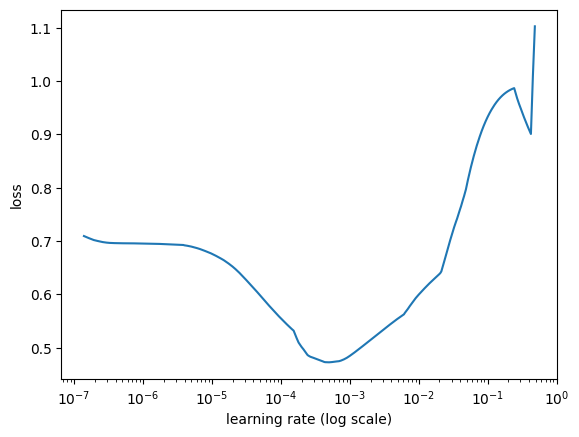

Duration: 488.71 seconds


In [ ]:
import time
train1, val1, preprocess1 = ktrain.text.texts_from_df(
    review_sample,
    "combined_text",
    label_columns=["health_wellness"],
    val_df=None,
    max_features=10000,
    maxlen=512,
    val_pct=0.1,
    ngram_range=1,
    preprocess_mode="distilbert",
    verbose=1
)

# Initializes a classifier model & create learner
model1 = preprocess1.get_classifier()
learner1 = ktrain.get_learner(model1, train_data=train1, val_data=val1, batch_size=16)

# Find best learning rate
start_time = time.time()
learner1.lr_find(max_epochs=5)
learner1.lr_plot()
print(f"Duration: {time.time()-start_time:.2f} seconds")

# Tune 2 ✒️ - reduce maxlen

maxlen is the max sequence the model can process at a time, shorter length can save some process time. Since the 99% of length of both training and testing set is below 70, let's try to reduce it to 100.

['not_health_wellness', 'health_wellness']
        not_health_wellness  health_wellness
24371                   1.0              0.0
123823                  0.0              1.0
172615                  0.0              1.0
158607                  0.0              1.0
57231                   1.0              0.0
['not_health_wellness', 'health_wellness']
        not_health_wellness  health_wellness
186264                  0.0              1.0
168972                  0.0              1.0
17693                   1.0              0.0
138865                  0.0              1.0
73688                   0.0              1.0
preprocessing train...
language: en
train sequence lengths:
	mean : 32
	95percentile : 58
	99percentile : 68


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 33
	95percentile : 61
	99percentile : 88


simulating training for different learning rates... this may take a few moments...
Epoch 1/5
112/112 [==============================] - 40s 170ms/step - loss: 0.6832 - accuracy: 0.5831
Epoch 2/5
112/112 [==============================] - 20s 175ms/step - loss: 0.4233 - accuracy: 0.8262
Epoch 3/5
112/112 [==============================] - 19s 173ms/step - loss: 0.6558 - accuracy: 0.5561
Epoch 4/5
112/112 [==============================] - 19s 166ms/step - loss: 1.1290 - accuracy: 0.4927
Epoch 5/5
112/112 [==============================] - 19s 169ms/step - loss: 0.9109 - accuracy: 0.5011


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


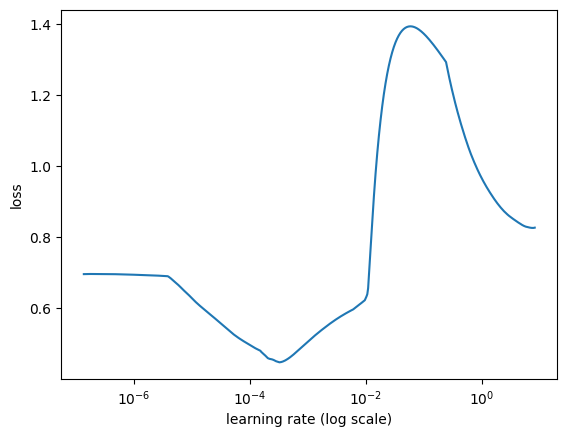

Duration: 174.07 seconds


In [ ]:
start_time = time.time()
train2, val2, preprocess2 = ktrain.text.texts_from_df(
    review_sample,
    "combined_text",
    label_columns=["health_wellness"],
    val_df=None,
    max_features=10000,
    maxlen=100,
    val_pct=0.1,
    ngram_range=1,
    preprocess_mode="distilbert",#"roberta","bert"
    verbose=1
)
model2 = preprocess2.get_classifier()
learner2 = ktrain.get_learner(model2, train_data=train2, val_data=val2, batch_size=16)
learner2.lr_find(max_epochs=5)
learner2.lr_plot()

print(f"Duration: {time.time()-start_time:.2f} seconds")

🔍Since performance doesn't seem to surfer, let's reduce the max length.

# Tune 3 ✒️ - increase max_features
Increasing max features can either help the performance. Let's see how tuning it affect the model.

['not_health_wellness', 'health_wellness']
        not_health_wellness  health_wellness
116403                  0.0              1.0
46047                   1.0              0.0
187635                  0.0              1.0
55466                   1.0              0.0
153308                  1.0              0.0
['not_health_wellness', 'health_wellness']
        not_health_wellness  health_wellness
195803                  1.0              0.0
196045                  1.0              0.0
191863                  0.0              1.0
36837                   1.0              0.0
140201                  0.0              1.0
preprocessing train...
language: en
train sequence lengths:
	mean : 32
	95percentile : 58
	99percentile : 70


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 31
	95percentile : 55
	99percentile : 63


simulating training for different learning rates... this may take a few moments...
Epoch 1/5
112/112 [==============================] - 42s 171ms/step - loss: 0.6830 - accuracy: 0.5625
Epoch 2/5
112/112 [==============================] - 20s 176ms/step - loss: 0.3986 - accuracy: 0.8481
Epoch 3/5
112/112 [==============================] - 20s 175ms/step - loss: 0.5995 - accuracy: 0.6295
Epoch 4/5
112/112 [==============================] - 9s 82ms/step - loss: 9.2342 - accuracy: 0.4989


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


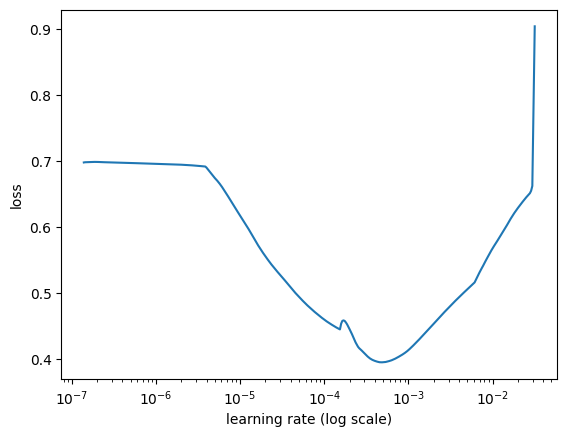

Duration: 103.67 seconds


In [ ]:
start_time = time.time()
train3, val3, preprocess3 = ktrain.text.texts_from_df(
    review_sample,
    "combined_text",
    label_columns=["health_wellness"],
    val_df=None,
    max_features=20000,
    maxlen=100,
    val_pct=0.1,
    ngram_range=1,
    preprocess_mode="distilbert",#"roberta","bert"
    verbose=1
)
model3 = preprocess3.get_classifier()
learner3 = ktrain.get_learner(model3, train_data=train3, val_data=val3, batch_size=16)
learner3.lr_find(max_epochs=5)
learner3.lr_plot()

print(f"Duration: {time.time()-start_time:.2f} seconds")

🔍The model does seem to improve model performance on trainign set after increaes the max features. However, be careful it could mean it's easier to overfit on testing set. (Although not shown here just to save some runing time,but I've played it a bit on testing set too and increase max features form 10000 to 20000 help on testing set too.).

# Tune 4 ✒️ - increase ngram_range
Increase ngram may help have postive impact o the model but sometimes increasing it may hurt performance instead. Also, it may increase training time.

['not_health_wellness', 'health_wellness']
        not_health_wellness  health_wellness
176327                  1.0              0.0
199365                  0.0              1.0
78000                   1.0              0.0
15745                   0.0              1.0
171986                  0.0              1.0
['not_health_wellness', 'health_wellness']
        not_health_wellness  health_wellness
168655                  0.0              1.0
70624                   1.0              0.0
184488                  1.0              0.0
187683                  0.0              1.0
153687                  1.0              0.0
preprocessing train...
language: en
train sequence lengths:
	mean : 32
	95percentile : 58
	99percentile : 69


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 33
	95percentile : 57
	99percentile : 68


simulating training for different learning rates... this may take a few moments...
Epoch 1/5
112/112 [==============================] - 86s 172ms/step - loss: 0.6749 - accuracy: 0.6049
Epoch 2/5
112/112 [==============================] - 20s 177ms/step - loss: 0.4225 - accuracy: 0.8318
Epoch 3/5
112/112 [==============================] - 19s 173ms/step - loss: 0.6407 - accuracy: 0.6087
Epoch 4/5
112/112 [==============================] - 16s 144ms/step - loss: 116.4096 - accuracy: 0.4882


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


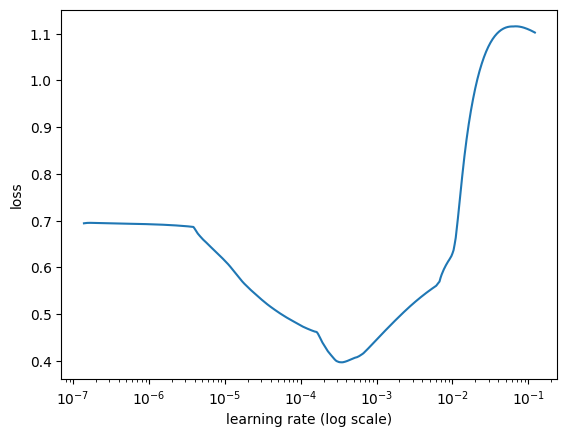

Duration: 161.07 seconds


In [ ]:
start_time = time.time()
train4, val4, preprocess4 = ktrain.text.texts_from_df(
    review_sample,
    "combined_text",
    label_columns=["health_wellness"],
    val_df=None,
    max_features=20000,
    maxlen=100,
    val_pct=0.1,
    ngram_range=(1,2),
    preprocess_mode="distilbert",#"roberta","bert"
    verbose=1
)
model4= preprocess4.get_classifier()
learner4 = ktrain.get_learner(model4, train_data=train4, val_data=val4, batch_size=16)
learner4.lr_find(max_epochs=5)
learner4.lr_plot()

print(f"Duration: {time.time()-start_time:.2f} seconds")

🔍 I don't see visible model performance improvement, I think it's not worth to increase ngrams.

Now, use the tuned learner to train the best mode, which is model #3.

Here, we define a limit of 10 epochs, but in reality, this should stop much sooner due to early stopping.

In [ ]:
history=learner3.autofit(
    1e-4,
    checkpoint_folder='checkpoint',
    epochs=10,
    early_stopping=True
)



begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/10
113/113 [==============================] - 51s 252ms/step - loss: 0.4496 - accuracy: 0.7961 - val_loss: 0.3716 - val_accuracy: 0.8750
Epoch 2/10
113/113 [==============================] - 23s 199ms/step - loss: 0.2319 - accuracy: 0.9111 - val_loss: 0.3274 - val_accuracy: 0.8700
Epoch 3/10
113/113 [==============================] - 22s 199ms/step - loss: 0.1401 - accuracy: 0.9539 - val_loss: 0.5194 - val_accuracy: 0.8550
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 2.
Weights from best epoch have been loaded into model.


Get the predictor

In [ ]:
predictor = ktrain.get_predictor(learner3.model, preproc=preprocess3)

Optionally, uncomment this code to save the predictor and reload it later. Note, the saved models can be quite large and may quickly use up space on your Google Drive.

In [ ]:
#predictor.save("drive/MyDrive/MSDSTextClassification_Lab2.healthy_living")

In [ ]:
validation = learner3.validate(val_data=val3, print_report=True)

7/7 [==============================] - 7s 114ms/step
              precision    recall  f1-score   support

           0       0.82      0.94      0.88        97
           1       0.93      0.81      0.86       103

    accuracy                           0.87       200
   macro avg       0.88      0.87      0.87       200
weighted avg       0.88      0.87      0.87       200



Keep in mind that we've reduced the training set for the sake of expediency. For your final analysis and project, you should complete a run of the full data set. Pay attention to the impact of the input data on the performance of the final model (i.e. the validation scores)

# Tune 5 ✒️ - increase sample sizes (use all positive samples and add same portion of negative samples)

In [ ]:
# use all positive samples, and add negative samples of same size
sample_amount = len(reviews[reviews['health_wellness']==1])
print("sample amount is:", sample_amount)
healthy = reviews[reviews['health_wellness'] == 1].sample(n=sample_amount)
not_healthy = reviews[reviews['health_wellness'] == 0].sample(n=sample_amount)
review_sample = pd.concat([healthy,not_healthy])

sample amount is: 24521


['not_health_wellness', 'health_wellness']
        not_health_wellness  health_wellness
76628                   1.0              0.0
161487                  0.0              1.0
129685                  1.0              0.0
38427                   1.0              0.0
45510                   1.0              0.0
['not_health_wellness', 'health_wellness']
        not_health_wellness  health_wellness
89058                   1.0              0.0
197447                  1.0              0.0
36183                   1.0              0.0
42284                   0.0              1.0
182788                  0.0              1.0
preprocessing train...
language: en
train sequence lengths:
	mean : 32
	95percentile : 58
	99percentile : 68


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 32
	95percentile : 58
	99percentile : 67


simulating training for different learning rates... this may take a few moments...
Epoch 1/5
2758/2758 [==============================] - 503s 171ms/step - loss: 0.4607 - accuracy: 0.8026
Epoch 2/5
2758/2758 [==============================] - 486s 176ms/step - loss: 0.2441 - accuracy: 0.9068
Epoch 3/5
2758/2758 [==============================] - 494s 179ms/step - loss: 0.5927 - accuracy: 0.6122
Epoch 4/5
2758/2758 [==============================] - 253s 92ms/step - loss: 1.1503 - accuracy: 0.5028


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


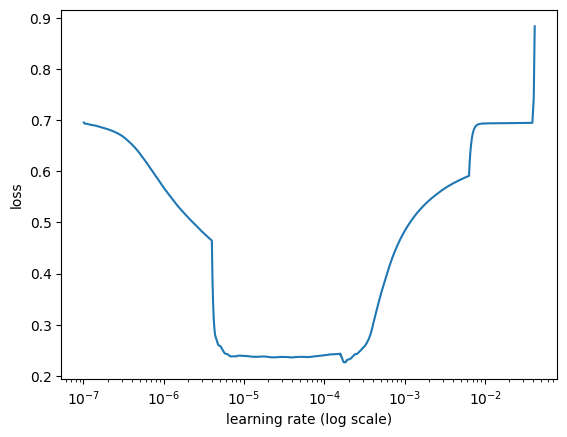

Duration: 1816.14 seconds


In [ ]:
start_time = time.time()
train5, val5, preprocess5 = ktrain.text.texts_from_df(
    review_sample,
    "combined_text",
    label_columns=["health_wellness"],
    val_df=None,
    max_features=20000,
    maxlen=100,
    val_pct=0.1,
    ngram_range=1,
    preprocess_mode="distilbert",#"roberta","bert"
    verbose=1
)
model5= preprocess5.get_classifier()
learner5 = ktrain.get_learner(model5, train_data=train5, val_data=val5, batch_size=16)
learner5.lr_find(max_epochs=5)
learner5.lr_plot()

print(f"Duration: {time.time()-start_time:.2f} seconds")

In [ ]:
history_final=learner5.autofit(
    1e-4,
    checkpoint_folder='checkpoint',
    epochs=10,
    early_stopping=True
)



begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/10
2759/2759 [==============================] - 570s 190ms/step - loss: 0.2504 - accuracy: 0.9030 - val_loss: 0.1994 - val_accuracy: 0.9223
Epoch 2/10
2759/2759 [==============================] - 510s 185ms/step - loss: 0.1504 - accuracy: 0.9456 - val_loss: 0.2175 - val_accuracy: 0.9199
Epoch 2: early stopping
Restoring model weights from the end of the best epoch: 1.
Weights from best epoch have been loaded into model.


In [ ]:
predictor_final = ktrain.get_predictor(learner5.model, preproc=preprocess5)
validation_final = learner5.validate(val_data=val5, print_report=True)

154/154 [==============================] - 20s 108ms/step
              precision    recall  f1-score   support

           0       0.94      0.91      0.92      2566
           1       0.90      0.94      0.92      2339

    accuracy                           0.92      4905
   macro avg       0.92      0.92      0.92      4905
weighted avg       0.92      0.92      0.92      4905



💡Compared with only 1,000 positive and 1,000 negative samples, the performance is much better with larger data size (24,521 positive samples and 24,521 negative samples. 24,521 is the size of all positive samples.) Now let's look at precision, recall, and f1-score. We will only focus on the positive class because that's what we are interested in.

-**Precision** for positive is 90% here. This means, **among the samples the model predict to be positive**, 90% is actually positive

-**Recall** for positive is 94% here. This means, **among all actual positive samples**, the model will correctly classify 94% of them as positive, and incorrectly classify the rest 6% of those positive samples as negative.

-**F1 score** for positive is 92% here. This is the sort of the average of precision and recall. 2/((1/precision)+(1/recall))


# Inspecting the drivers of prediction

No matter what the supervised machine learning model, you always want to peak under the hood to see what features are driving prediction. That is, what words sway the outcome of the prediction. It's harder to inspect a neural network. Because all of the layers of a neural network aren't really interpretable to the human eye.

Currently, the best practice I've found is a little tool Explainable AI:
https://alvinntnu.github.io/python-notes/nlp/ktrain-tutorial-explaining-predictions.html

In [ ]:
!pip3 install -q git+https://github.com/amaiya/eli5@tfkeras_0_10_1

  Preparing metadata (setup.py) ... done


Let's go ahead and make a little set of test documents to check out

In [ ]:
test_docs = [
'Stress May Be Your Heart’s Worst Enemy Psychological stress activates the fear center in the brain, setting into motion a cascade of reactions that can lead to heart attacks and strokes.',
'Exercising to Slim Down? Try Getting Bigger. It’s high time for women to reclaim the real strength behind exercise.',
'What Are Your Food Resolutions for the New Year? Join us for the Eat Well Challenge starting in January.',
'Why We All Need to Have More Fun. Prioritizing fun may feel impossible right now. But this four-step plan will help you rediscover how to feel more alive.',
'Cuomo Will Not Be Prosecuted in Groping Case, Albany D.A. Says. The district attorney described the woman who said former Gov. Andrew Cuomo had groped her as “credible,” but added that proving her allegation would be difficult.',
'A Film Captures Jewish Life in a Polish Town Before the Nazis Arrived. A documentary based on a home movie shot by an American in 1938 provides a look at the vibrancy of a Jewish community in Europe just before the Holocaust.',
              'Diversity is the key to a healthy society. Here is what we need to do to make america a more equitable place to live for all.'
             ]

In [ ]:
for i, text in enumerate(test_docs):
  probs = predictor_final.predict(text, return_proba=True)
  print("---------------------------")
  print('The probability this is healthy is %s' % probs[1])
  print(text)

---------------------------
The probability this is healthy is 0.98635304
Stress May Be Your Heart’s Worst Enemy Psychological stress activates the fear center in the brain, setting into motion a cascade of reactions that can lead to heart attacks and strokes.
---------------------------
The probability this is healthy is 0.9704353
Exercising to Slim Down? Try Getting Bigger. It’s high time for women to reclaim the real strength behind exercise.
---------------------------
The probability this is healthy is 0.9382685
What Are Your Food Resolutions for the New Year? Join us for the Eat Well Challenge starting in January.
---------------------------
The probability this is healthy is 0.88212293
Why We All Need to Have More Fun. Prioritizing fun may feel impossible right now. But this four-step plan will help you rediscover how to feel more alive.
---------------------------
The probability this is healthy is 0.0066464436
Cuomo Will Not Be Prosecuted in Groping Case, Albany D.A. Says. The

*These* are pretty obvious examples, but it works exactly as expected!

In [ ]:
!pip install https://github.com/amaiya/eli5-tf/archive/refs/heads/master.zip


     \ 6.9 MB 15.9 MB/s 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=108164 sha256=2c096b5a4ff76161424b2aadf59f1ff1929d10cdc93387761ca4560832dacec5
  Stored in directory: /tmp/pip-ephem-wheel-cache-il6b9c4z/wheels/0b/14/54/23c07f7254b733dc3daac99ba1fda60e30f1b2991b3b8ee0bf
Successfully built eli5
  Attempting uninstall: eli5
    Found existing installation: eli5 0.10.1
    Uninstalling eli5-0.10.1:
      Successfully uninstalled eli5-0.10.1


In [ ]:
predictor_final.explain('Diversity is the key to a healthy society. Here is what we need to do to make america a more equitable place to live for all.')